# Recomendation using Collaborative Filtering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model


In [2]:
from google.colab import files
uploaded = files.upload()

Saving culinary_rating (3).csv to culinary_rating (3).csv


## upload data

In [3]:
rating = pd.read_csv('culinary_rating (3).csv')

In [4]:
rating.head()

,User_Id,Place_Id,Culinary_Ratings
0,1,5,5
1,1,15,3
2,1,20,4
3,1,21,2
4,1,41,5


In [5]:
rating.shape

(5692, 3)

In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5692 entries, 0 to 5691
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   User_Id           5692 non-null   int64
 1   Place_Id          5692 non-null   int64
 2   Culinary_Ratings  5692 non-null   int64
dtypes: int64(3)
memory usage: 133.5 KB


#### split data for train and for test

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rating, test_size=0.2, random_state=42)

In [8]:
train.head()

,User_Id,Place_Id,Culinary_Ratings
2857,103,168,5
43,2,321,3
1891,68,123,1
3194,114,339,5
5080,179,260,5


In [9]:
test.head()

,User_Id,Place_Id,Culinary_Ratings
1436,53,45,5
748,28,357,3
3460,125,37,3
1448,53,174,2
5648,199,209,2


In [10]:
n_users = len(rating.User_Id.unique())
n_users

200

In [11]:
n_places = len(rating.Place_Id.unique())
n_places

371

## Neural Network

Neural networks have demonstrated their effectiveness across a wide range of machine learning challenges and consistently excel in the realm of recommendation systems.

In [12]:
# creating book embedding path
place_input = Input(shape=[1], name="Place-Input")
place_embedding = Embedding(n_places+1, 5, name="Place-Embedding")(place_input)
place_vec = Flatten(name="Flatten-Place")(place_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([place_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(64, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model = Model([user_input, place_input], out)
model.compile('adam', 'mean_squared_error')

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Place-Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 User-Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Place-Embedding (Embedding  (None, 1, 5)                 1860      ['Place-Input[0][0]']         
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 5)                 1005      ['User-Input[0][0]']      

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.20):
      print('sesuai harapan')
      self.model.stop_training = True

In [15]:
history = model.fit([train.User_Id, train.Place_Id], train.Culinary_Ratings, epochs=100, verbose=1, callbacks = [myCallback()])


Epoch 1/100
143/143 [==============================] - 1s 2ms/step - loss: 4.0875
Epoch 2/100
143/143 [==============================] - 0s 2ms/step - loss: 1.7839
Epoch 3/100
143/143 [==============================] - 0s 2ms/step - loss: 1.7390
Epoch 4/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6933
Epoch 5/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6774
Epoch 6/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6632
Epoch 7/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6541
Epoch 8/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6502
Epoch 9/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6383
Epoch 10/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6348
Epoch 11/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6287
Epoch 12/100
143/143 [==============================] - 0s 2ms/step - loss: 1.6260
Epoch 13/100


Text(0, 0.5, 'Training Error')

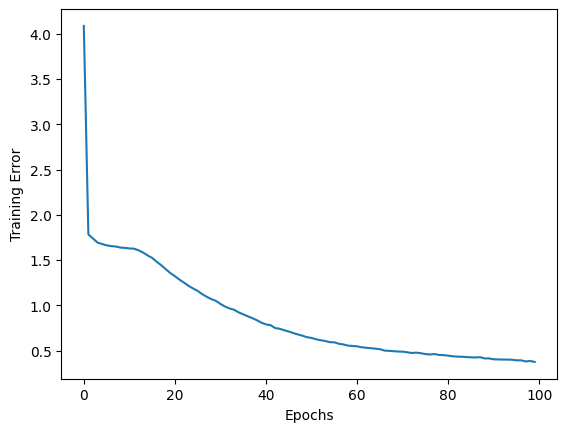

In [16]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [20]:
model.evaluate([test.User_Id, test.Place_Id], test.Culinary_Ratings)

36/36 [==============================] - 0s 2ms/step - loss: 3.9170


3.9170315265655518

In [21]:
model.save('recommendation_rating_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
id_place = range(1,20)

In [23]:
# Creating dataset for making recommendations for the first user
place_data = np.array(list(set(rating.Place_Id)))
place_data[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [24]:
id_user = 3

In [25]:
user = np.array([id_user for i in range(len(place_data))])
user[:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Predict

In [26]:
predictions = model.predict([user, place_data])

predictions = np.array([a[0] for a in predictions])

recommended_place_ids = (-predictions).argsort()[:10]

recommended_place_ids

12/12 [==============================] - 0s 2ms/step


array([190, 237,  19, 152, 276, 231, 145,  92, 138, 304])

In [27]:
# print predicted scores
predictions[recommended_place_ids]

array([6.6822658, 6.665669 , 6.5480065, 6.495582 , 6.4850554, 6.4249616,
       6.3754992, 6.3342957, 6.166776 , 6.1285205], dtype=float32)